# Interactive Tutorial

This tutorial showing the step-by-step process of running ONTraC on stereo-seq mouse midbrain dataset through Jupyter Lab.

## Prepare

### The hardware environment used for this tutorial

#### CPU
we only use 4 CPU here.

In [1]:
%%bash

lscpu

Architecture:                       x86_64
CPU op-mode(s):                     32-bit, 64-bit
Address sizes:                      46 bits physical, 57 bits virtual
Byte Order:                         Little Endian
CPU(s):                             96
On-line CPU(s) list:                0-95
Vendor ID:                          GenuineIntel
Model name:                         INTEL(R) XEON(R) PLATINUM 8568Y+
CPU family:                         6
Model:                              207
Thread(s) per core:                 1
Core(s) per socket:                 48
Socket(s):                          2
Stepping:                           2
Frequency boost:                    enabled
CPU(s) scaling MHz:                 100%
CPU max MHz:                        2301.0000
CPU min MHz:                        800.0000
BogoMIPS:                           4600.00
Flags:                              fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse

#### GPU

In [2]:
%%bash

nvidia-smi

Wed Jan 15 12:46:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 80GB HBM3          On  |   00000000:3D:00.0 Off |                  Off |
| N/A   26C    P0             67W /  700W |       1MiB /  81559MiB |      0%   E. Process |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### install ONTraC

Skip this if you've installed ONTraC already.

In [3]:
%%bash

source ~/.bash_profile  # change it to "source ~/.zshrc" if you are using zsh

conda activate ONTraC  # ONTraC is the conda environment name

pip install "ONTraC[analysis]==1.*"


The following have been reloaded with a version change:
  1) gcc/14.2.0 => gcc/11.2.0



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 10.0 MB/s eta 0:00:00


### Load Modules

In [4]:
# fake options
from optparse import Values

In [5]:
# ONTraC running modules
from ONTraC.run.processes import niche_trajectory_construct, gnn, load_parameters, niche_network_construct
from ONTraC.utils import write_version_info
from ONTraC.integrate.general_control import options_valid

In [6]:
# ONTraC analysis modules
from ONTraC.analysis.data import AnaData

In [7]:
# visualization modules

import matplotlib as mpl
import numpy as np
import pandas as pd

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns

### create directories

In [8]:
import os

os.makedirs('figures', exist_ok=True)
os.makedirs('log', exist_ok=True)
os.makedirs('output', exist_ok=True)

### validate ONTraC version info

In [9]:
write_version_info()

##################################################################################

         ▄▄█▀▀██   ▀█▄   ▀█▀ █▀▀██▀▀█                   ▄▄█▀▀▀▄█
        ▄█▀    ██   █▀█   █     ██    ▄▄▄ ▄▄   ▄▄▄▄   ▄█▀     ▀
        ██      ██  █ ▀█▄ █     ██     ██▀ ▀▀ ▀▀ ▄██  ██
        ▀█▄     ██  █   ███     ██     ██     ▄█▀ ██  ▀█▄      ▄
         ▀▀█▄▄▄█▀  ▄█▄   ▀█    ▄██▄   ▄██▄    ▀█▄▄▀█▀  ▀▀█▄▄▄▄▀

                        version: 1.1.3

##################################################################################


## Download dataset

In [10]:
import requests

# URL of the file
url = "https://zenodo.org/records/14519865/files/Stereo_seq_data.zip"

# Local file path to save the file
file_path = "./Stereo_seq_data.zip"

try:
    # Send a GET request to the URL
    response = requests.get(url)
    response.raise_for_status()  # Check if the request was successful

    # Write the content to the file
    with open(file_path, "wb") as file:
        file.write(response.content)

    print(f"File downloaded and saved to {file_path}")
except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")


File downloaded and saved to ./Stereo_seq_data.zip


In [11]:
import zipfile

# Path to the zip file
zip_file_path = "Stereo_seq_data.zip"

# Directory where files will be extracted
extract_to_path = "./"

try:
    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all files to the specified directory
        zip_ref.extractall(extract_to_path)

    print(f"Files extracted to '{extract_to_path}'")
except zipfile.BadZipFile:
    print("The file is not a valid zip file.")


Files extracted to './'


## Input data

In [12]:
input_file = './Stereo_seq_data/preprocessing/stereo_input.csv'

meta_df = pd.read_csv(input_file, index_col=0)
meta_df.head()

Sample Cell_Type        x        y
Cell_ID                                              
E12_E1S3_100034  E12_E1S3     Fibro  15940.0  18584.0
E12_E1S3_100035  E12_E1S3     Fibro  15942.0  18623.0
E12_E1S3_100191  E12_E1S3      Endo  15965.0  18619.0
E12_E1S3_100256  E12_E1S3     Fibro  15969.0  18717.0
E12_E1S3_100264  E12_E1S3     Fibro  15974.0  18692.0

### Input data visualization

In [13]:
from ONTraC.analysis.cell_type import plot_spatial_cell_type_distribution_dataset

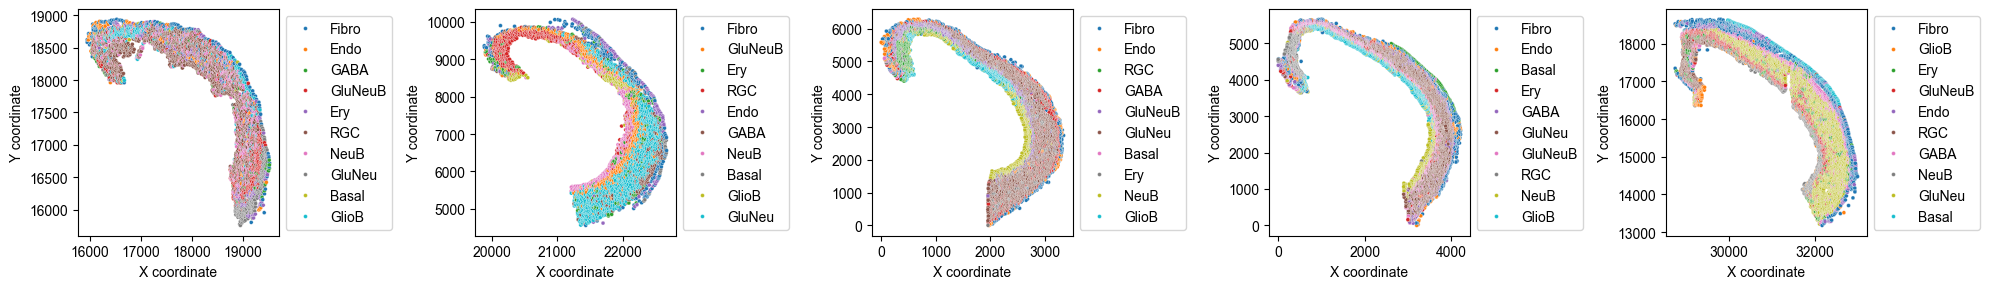

In [14]:
fig, ax = plot_spatial_cell_type_distribution_dataset(meta_df)
fig.savefig('figures/Spatial_cell_type.png', dpi=300)

## set up options

In [15]:
run_options = Values()
run_options.NN_dir = './output/stereo_seq_NN'
run_options.GNN_dir = './output/stereo_seq_GNN'
run_options.NT_dir = './output/stereo_seq_NT'
run_options.meta_input = input_file
run_options.n_neighbors = 50
run_options.device = 'cuda'
run_options.epochs = 1000
run_options.hidden_feats = 4
run_options.n_gcn_layers = 2
run_options.k = 6
run_options.modularity_loss_weight = 0.3
run_options.purity_loss_weight = 300.0
run_options.regularization_loss_weight = 0.1
run_options.beta = 0.03
run_options.trajectory_construct = 'BF'


In [16]:
run_options = options_valid(run_options)

12:51:08 --- WARNING: The directory (./output/stereo_seq_NN) you given already exists. It will be overwritten.
12:51:08 --- WARNING: The directory (./output/stereo_seq_GNN) you given already exists. It will be overwritten.
12:51:08 --- WARNING: The directory (./output/stereo_seq_NT) you given already exists. It will be overwritten.


12:51:08 --- INFO: ------------------ RUN params memo ------------------ 
12:51:08 --- INFO:             -------- I/O options -------             
12:51:08 --- INFO: Niche network output directory:  ./output/stereo_seq_NN
12:51:08 --- INFO: GNN output directory:  ./output/stereo_seq_GNN
12:51:08 --- INFO: Niche trajectory output directory:  ./output/stereo_seq_NT
12:51:08 --- INFO: Meta data file:  ./Stereo_seq_data/preprocessing/stereo_input.csv
12:51:08 --- INFO:       -------- niche net constr options -------      
12:51:08 --- INFO: n_cpu:   4
12:51:08 --- INFO: n_neighbors: 50
12:51:08 --- INFO: n_local: 20
12:51:08 --- INFO:            -------- train options -------            
12:51:08 --- INFO: device:  cuda
12:51:08 --- INFO: epochs:  1000
12:51:08 --- INFO: batch_size:  0
12:51:08 --- INFO: patience:  100
12:51:08 --- INFO: min_delta:  0.001
12:51:08 --- INFO: min_epochs:  50
12:51:08 --- INFO: seed:  42
12:51:08 --- INFO: lr:  0.03
12:51:08 --- INFO: hidden_feats:  4
12:51:0

In [17]:
vis_options = Values()
vis_options.NN_dir = run_options.NN_dir
vis_options.GNN_dir = run_options.GNN_dir
vis_options.NT_dir = run_options.NT_dir
vis_options.output = None
vis_options.reverse = True


## niche network construction

![niche_net_illustrator](../images/other/niche_net_illustrator.png)

![niche_feat_calculate](../images/other/niche_feat_calculate.png)

In [18]:
niche_network_construct(options=run_options)

12:51:10 --- INFO: ------------- Niche network construct --------------- 
12:51:11 --- INFO: Constructing niche network for sample: E12_E1S3.
12:51:11 --- INFO: Building KNN network for sample: E12_E1S3...
12:51:11 --- INFO: Calculating edge index for sample: E12_E1S3...
12:51:11 --- INFO: Calculating niche weight matrix for sample: E12_E1S3...
12:51:11 --- INFO: Calculating cell type composition for sample: E12_E1S3...
12:51:13 --- INFO: Constructing niche network for sample: E14_E1S3.
12:51:13 --- INFO: Building KNN network for sample: E14_E1S3...
12:51:13 --- INFO: Calculating edge index for sample: E14_E1S3...
12:51:13 --- INFO: Calculating niche weight matrix for sample: E14_E1S3...
12:51:13 --- INFO: Calculating cell type composition for sample: E14_E1S3...
12:51:14 --- INFO: Constructing niche network for sample: E16_E1S3.
12:51:14 --- INFO: Building KNN network for sample: E16_E1S3...
12:51:14 --- INFO: Calculating edge index for sample: E16_E1S3...
12:51:14 --- INFO: Calculati

### niche network visulization

In [19]:
ana_data = AnaData(vis_options)

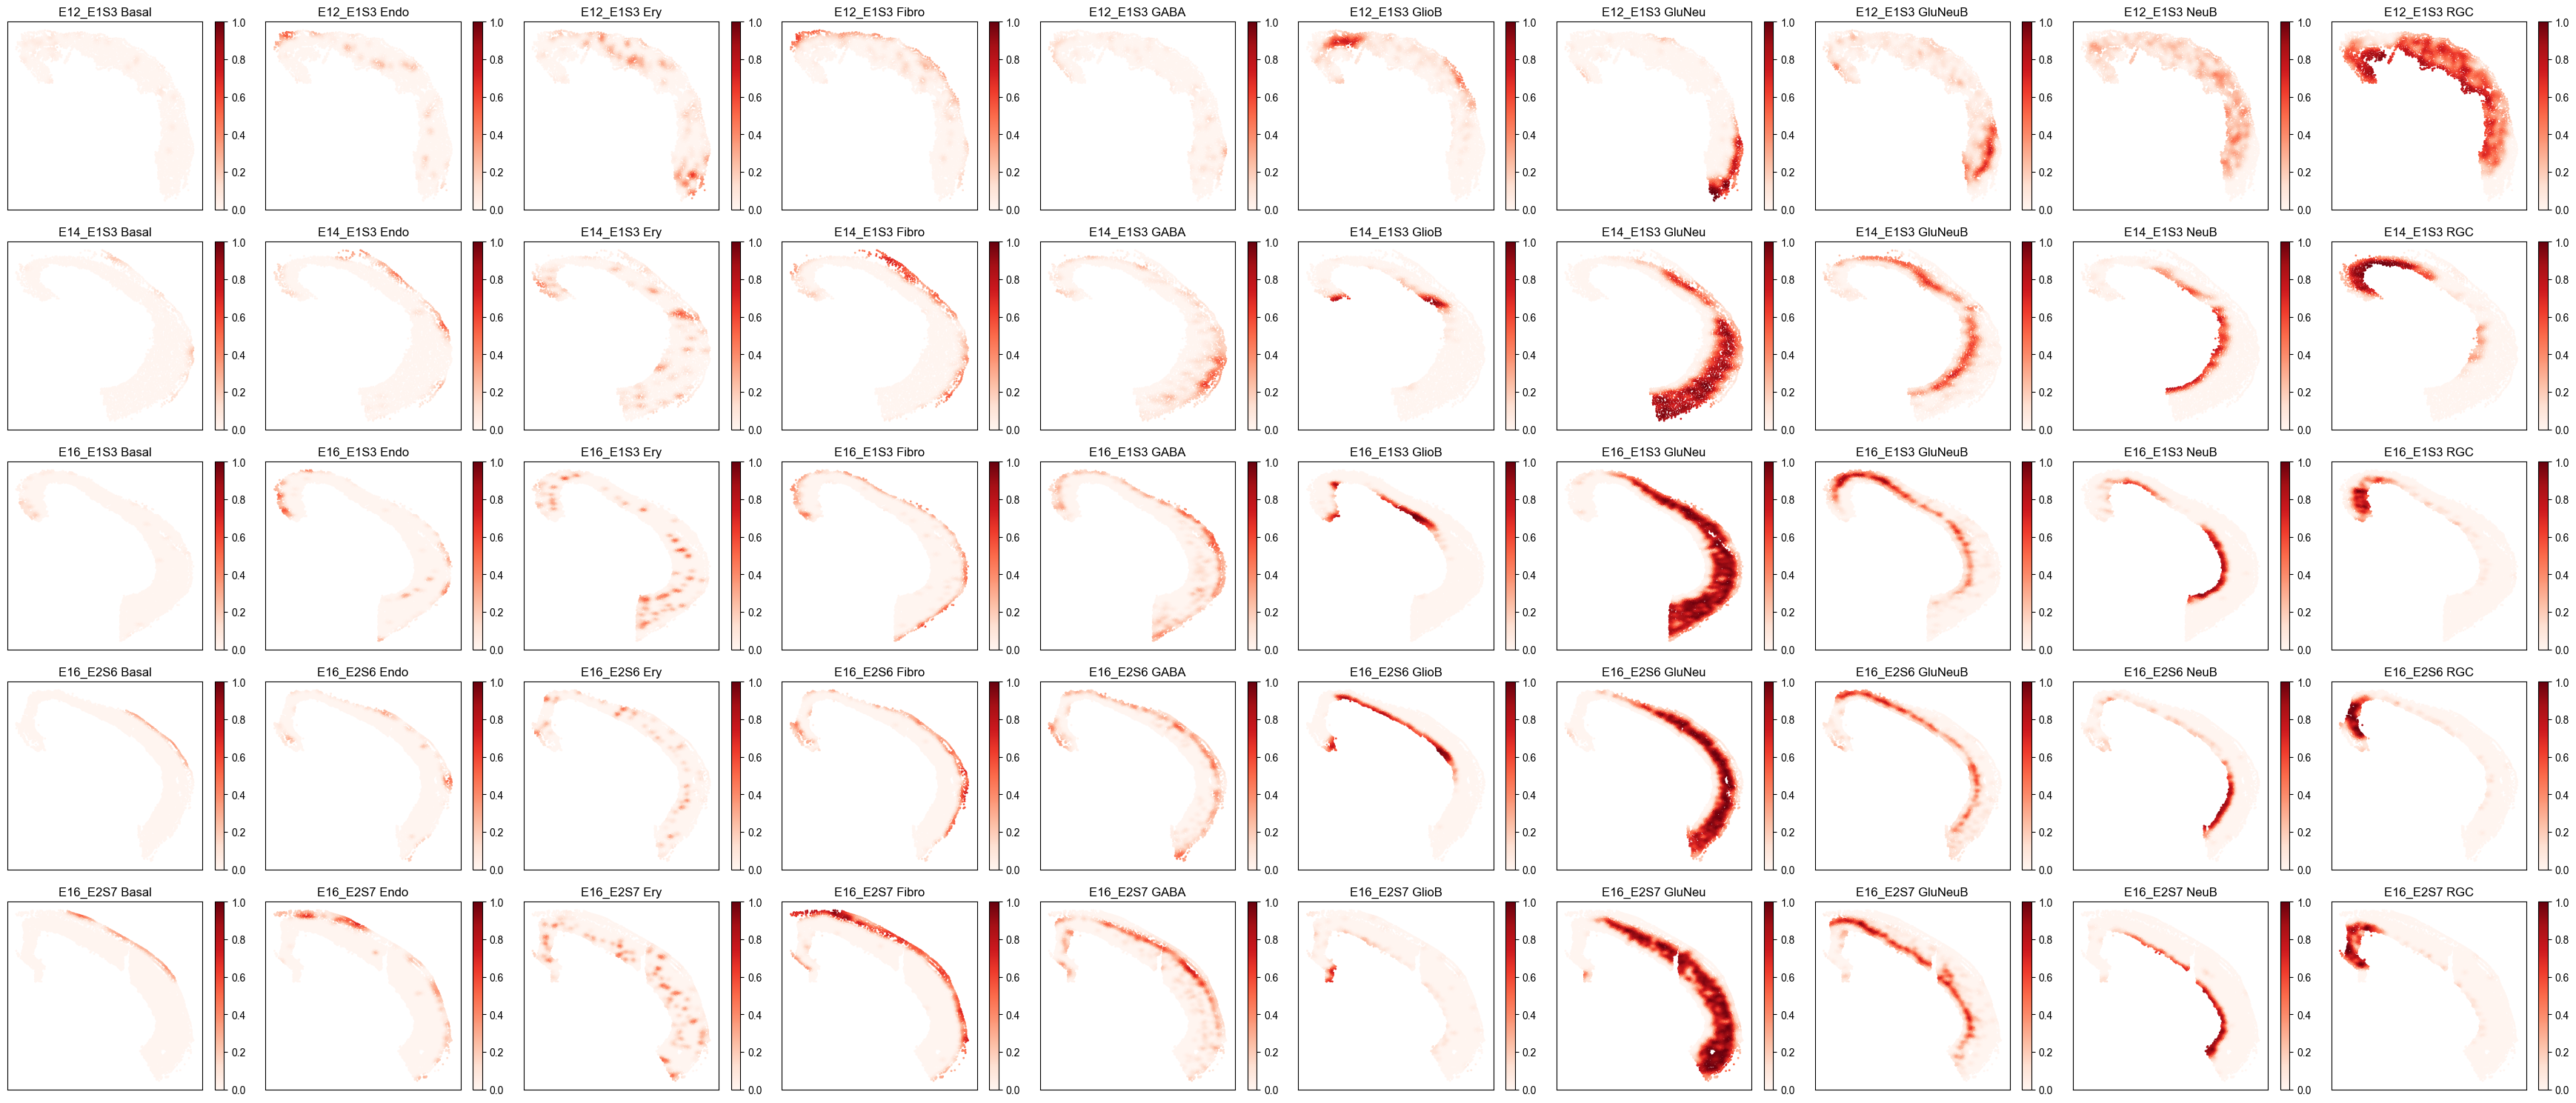

In [20]:
from ONTraC.analysis.spatial import plot_cell_type_composition_dataset_from_anadata

fig, axes = plot_cell_type_composition_dataset_from_anadata(ana_data)
fig.savefig('figures/Spatial_cell_type_composition.png', dpi=300)

This figure shows cell type composition of niches across samples. Rows represent samples, and columns denote specific cell types. The position of each niche is based on its anchor cell. Cell type compositions within each niche are normalized to a total of 1.

## GNN training

![gnn](../images/other/gnn.png)

![gnn formula](../images/other/gnn_formulas.png)

In [21]:
# It's will run much faster using GPU
gnn(options=run_options)

12:51:44 --- INFO: ------------------------ GNN ------------------------ 
12:51:44 --- INFO: Loading dataset.
12:51:44 --- INFO: Maximum number of cell in one sample is: 7300.
12:51:44 --- INFO: Processing sample 1 of 5: E12_E1S3
12:51:44 --- INFO: Processing sample 2 of 5: E14_E1S3
12:51:44 --- INFO: Processing sample 3 of 5: E16_E1S3
12:51:44 --- INFO: Processing sample 4 of 5: E16_E2S6
12:51:44 --- INFO: Processing sample 5 of 5: E16_E2S7


Processing...


12:51:44 --- INFO: Processing sample 1 of 5: E12_E1S3
12:51:44 --- INFO: Processing sample 2 of 5: E14_E1S3
12:51:44 --- INFO: Processing sample 3 of 5: E16_E1S3
12:51:44 --- INFO: Processing sample 4 of 5: E16_E2S6
12:51:44 --- INFO: Processing sample 5 of 5: E16_E2S7


Done!


12:51:48 --- INFO: epoch: 1, batch: 1, loss: 9.778472900390625, modularity_loss: -5.301945293467725e-06, purity_loss: 9.703614234924316, regularization_loss: 0.074863962829113
12:51:49 --- INFO: epoch: 2, batch: 1, loss: 9.77786922454834, modularity_loss: -1.015456837194506e-05, purity_loss: 9.703018188476562, regularization_loss: 0.07486078143119812
12:51:49 --- INFO: epoch: 3, batch: 1, loss: 9.776715278625488, modularity_loss: -1.7354162991978228e-05, purity_loss: 9.701872825622559, regularization_loss: 0.07485990971326828
12:51:49 --- INFO: epoch: 4, batch: 1, loss: 9.774765968322754, modularity_loss: -2.81233496934874e-05, purity_loss: 9.699932098388672, regularization_loss: 0.07486207038164139
12:51:50 --- INFO: epoch: 5, batch: 1, loss: 9.771647453308105, modularity_loss: -4.370275200926699e-05, purity_loss: 9.696822166442871, regularization_loss: 0.07486861944198608
12:51:50 --- INFO: epoch: 6, batch: 1, loss: 9.766881942749023, modularity_loss: -6.566625233972445e-05, purity_l

### GNN results visualization

In [22]:
ana_data = AnaData(vis_options)

#### spatial niche cluster loadings

12:57:34 --- WARNING: Cannot find niche cluster score file: ./output/stereo_seq_NT/niche_cluster_score.csv.


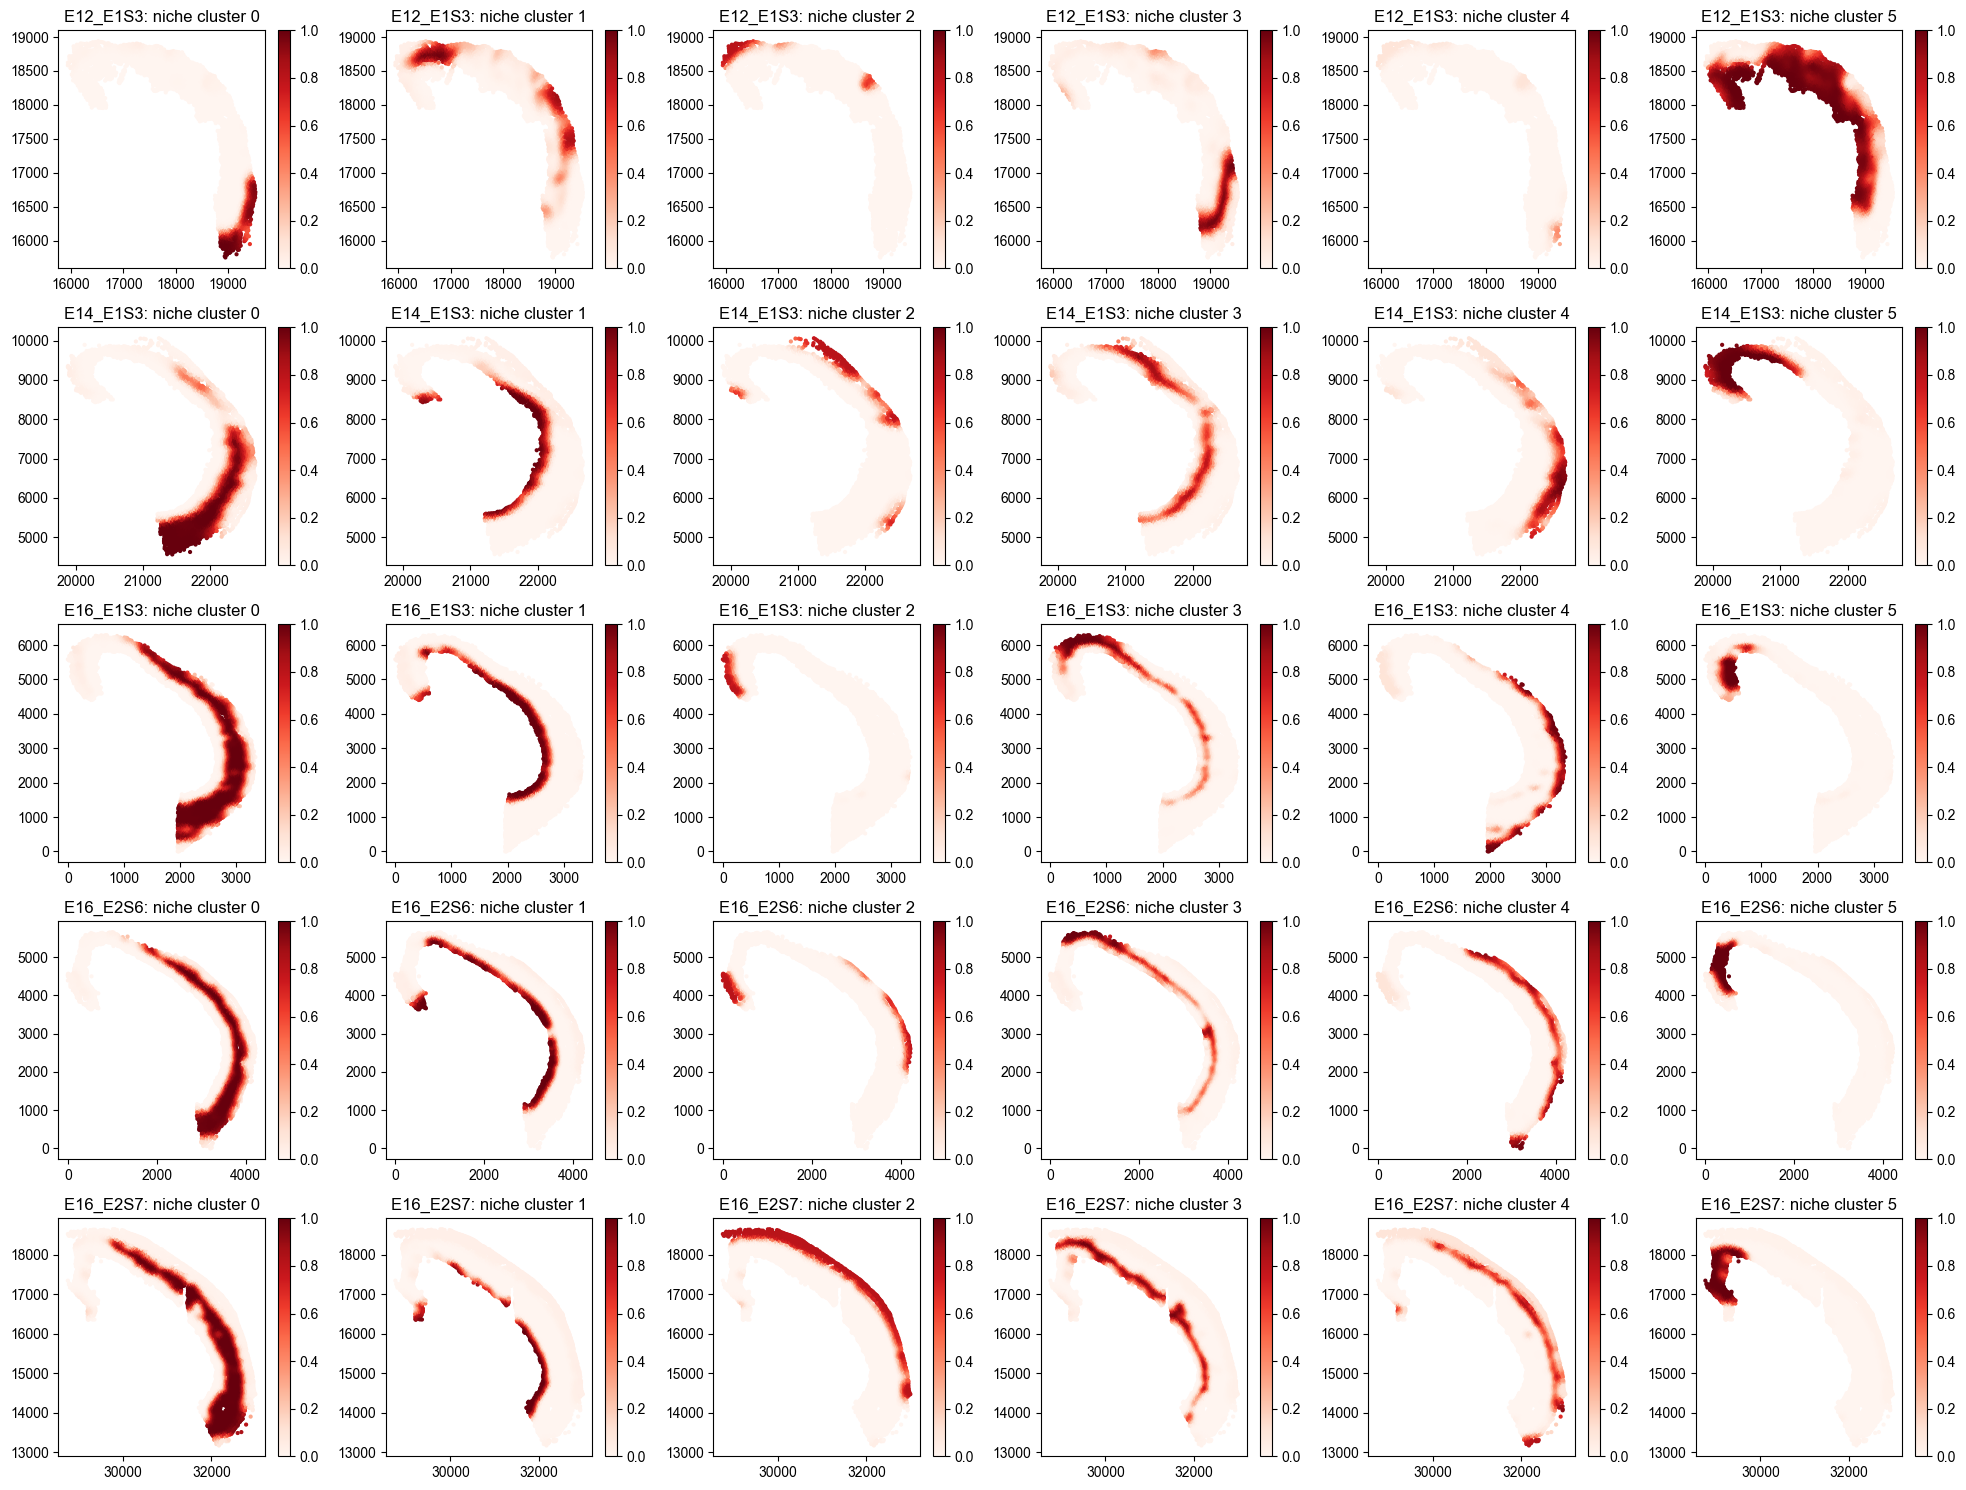

In [23]:
from ONTraC.analysis.niche_cluster import plot_niche_cluster_loadings_dataset_from_anadata

fig, axes = plot_niche_cluster_loadings_dataset_from_anadata(ana_data=ana_data)
fig.savefig('figures/Spatial_niche_clustering_loadings.png', dpi=100)

#### niche cluster proportions

12:57:42 --- WARNING: Cannot find niche cluster score file: ./output/stereo_seq_NT/niche_cluster_score.csv.


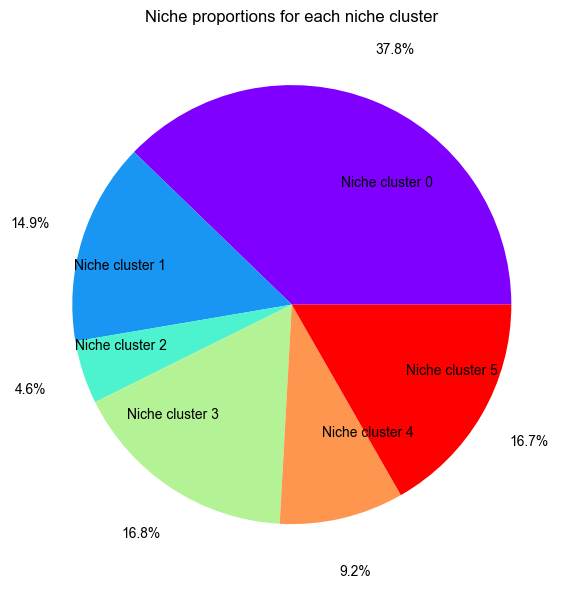

In [24]:
from ONTraC.analysis.niche_cluster import plot_cluster_proportion_from_anadata

fig, ax = plot_cluster_proportion_from_anadata(ana_data=ana_data)
fig.savefig('figures/Pie_niche_cluster_proportions.png', dpi=100)

#### niche cluster connectivities

12:57:42 --- WARNING: Cannot find niche cluster score file: ./output/stereo_seq_NT/niche_cluster_score.csv.


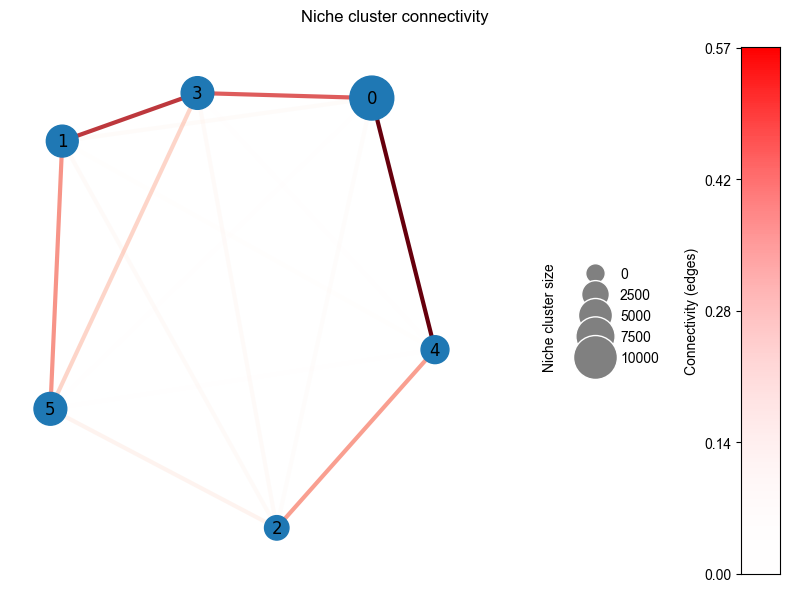

In [25]:
from ONTraC.analysis.niche_cluster import plot_niche_cluster_connectivity_from_anadata

fig, axes = plot_niche_cluster_connectivity_from_anadata(ana_data=ana_data)
fig.savefig('figures/Graph_niche_cluster_conn.png', dpi=100)

#### cell type loadings in each niche cluster

12:57:43 --- WARNING: Cannot find niche cluster score file: ./output/stereo_seq_NT/niche_cluster_score.csv.


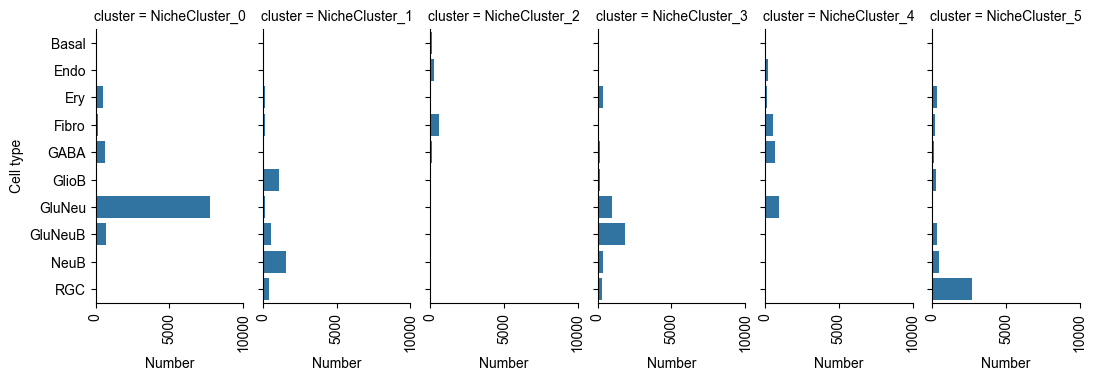

In [26]:
from ONTraC.analysis.cell_type import plot_cell_type_loading_in_niche_clusters_from_anadata

g = plot_cell_type_loading_in_niche_clusters_from_anadata(ana_data=ana_data)
g.savefig('figures/Hist_cell_type_loadings_in_niche_cluster.png', dpi=100)

12:57:44 --- WARNING: Cannot find niche cluster score file: ./output/stereo_seq_NT/niche_cluster_score.csv.


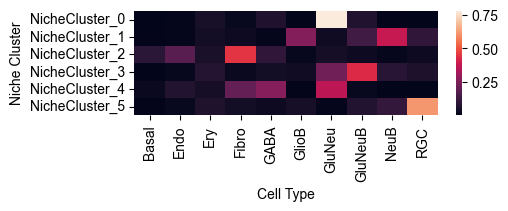

In [27]:
from ONTraC.analysis.cell_type import plot_cell_type_com_in_niche_clusters_from_anadata

fig, ax = plot_cell_type_com_in_niche_clusters_from_anadata(ana_data=ana_data)
fig.savefig('figures/Heatmap_cell_type_composition_in_each_niche_cluster.png', dpi=100)

This heatmap show the cell type composition within each niche cluster. Sum of each row equals to 1.

12:57:44 --- WARNING: Cannot find niche cluster score file: ./output/stereo_seq_NT/niche_cluster_score.csv.


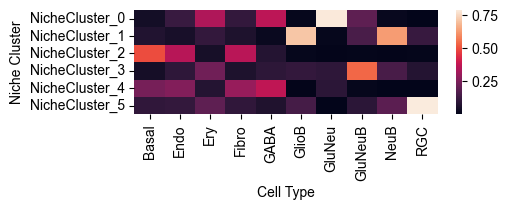

In [28]:
from ONTraC.analysis.cell_type import plot_cell_type_dis_across_niche_cluster_from_anadata

fig, ax = plot_cell_type_dis_across_niche_cluster_from_anadata(ana_data=ana_data)
fig.savefig('figures/Heatmap_cell_type_distribution_across_niche_clusters.png', dpi=100)

This heatmap show the cell type distribution across niche clusters. Sum of each column equals to 1.

## niche trajectory construction

![niche trajectory](../images/other/niche_trajectory.png)

### construct niche trajectory

In [29]:
niche_trajectory_construct(options=run_options)

12:57:44 --- INFO: ----------------- Niche trajectory ------------------ 
12:57:44 --- INFO: Loading consolidate s_array and out_adj_array...
12:57:44 --- INFO: Maximum number of cell in one sample is: 7300.
12:57:44 --- INFO: Processing sample 1 of 5: E12_E1S3
12:57:44 --- INFO: Processing sample 2 of 5: E14_E1S3
12:57:44 --- INFO: Processing sample 3 of 5: E16_E1S3
12:57:44 --- INFO: Processing sample 4 of 5: E16_E2S6


Processing...


12:57:44 --- INFO: Processing sample 5 of 5: E16_E2S7
12:57:45 --- INFO: Processing sample 1 of 5: E12_E1S3
12:57:45 --- INFO: Processing sample 2 of 5: E14_E1S3
12:57:45 --- INFO: Processing sample 3 of 5: E16_E1S3
12:57:45 --- INFO: Processing sample 4 of 5: E16_E2S6
12:57:45 --- INFO: Processing sample 5 of 5: E16_E2S7


Done!


12:57:45 --- INFO: Calculating NTScore for each niche.
12:57:45 --- INFO: Finding niche trajectory with maximum connectivity using Brute Force.
12:57:45 --- INFO: Calculating NTScore for each niche cluster based on the trajectory path.
12:57:45 --- INFO: Projecting NTScore from niche-level to cell-level.
12:57:45 --- INFO: Output NTScore tables.
12:57:46 --- INFO: --------------- Niche trajectory end ---------------- 


### niche trajectory based visualization

In [30]:
ana_data = AnaData(vis_options)

#### spatial NT scores

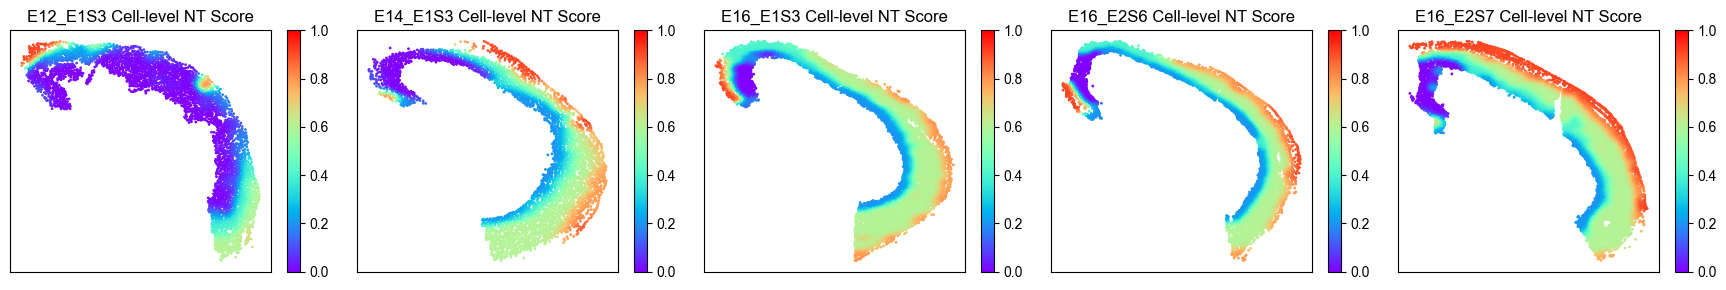

In [31]:
#cell-level NT score
from ONTraC.analysis.spatial import plot_cell_NT_score_dataset_from_anadata

fig, ax = plot_cell_NT_score_dataset_from_anadata(ana_data)
fig.savefig('figures/Spatial_cell_NT_score.png', dpi=100)

#### cell-level NT score distribution for each cell type

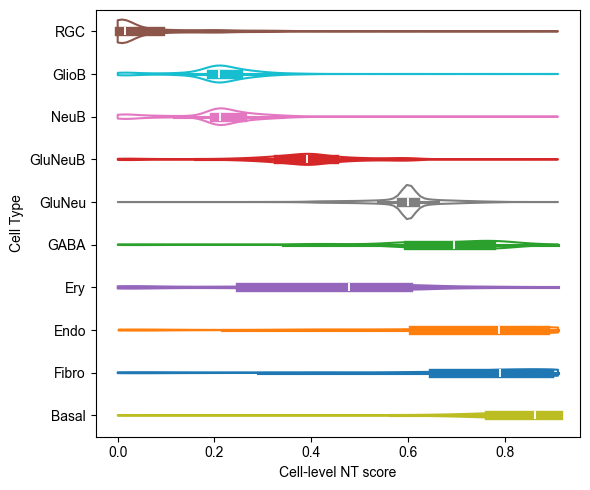

In [32]:
from ONTraC.analysis.cell_type import plot_violin_cell_type_along_NT_score_from_anadata

fig, ax = plot_violin_cell_type_along_NT_score_from_anadata(ana_data=ana_data,
                                                            order=['RGC', 'GlioB', 'NeuB', 'GluNeuB', 'GluNeu', 'GABA', 'Ery', 'Endo', 'Fibro', 'Basal'],  # change based on your own dataset or remove this line
                                                           )
fig.savefig('figures/cell_type_along_NT_score_violin.png', dpi=100)

#### cell type propotion along cell-level NT score

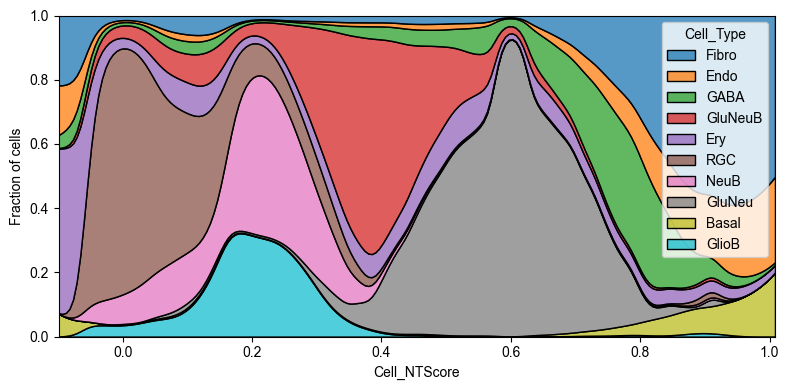

In [33]:
from ONTraC.analysis.cell_type import plot_kde_cell_type_along_NT_score_from_anadata

fig, ax = plot_kde_cell_type_along_NT_score_from_anadata(ana_data=ana_data)
fig.savefig('figures/cell_type_along_NT_score_kde.png', dpi=100)

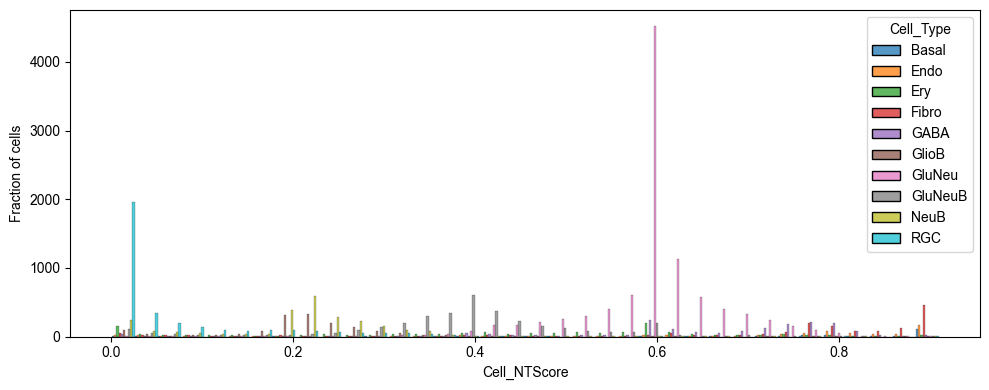

In [34]:
from ONTraC.analysis.cell_type import plot_hist_cell_type_along_NT_score_from_anadata

fig, ax = plot_hist_cell_type_along_NT_score_from_anadata(ana_data=ana_data)
fig.savefig('figures/cell_type_along_NT_score_hist.png', dpi=100)


#### We can reorder niche clusters by their position in trajectory



##### spatial niche cluster loadings


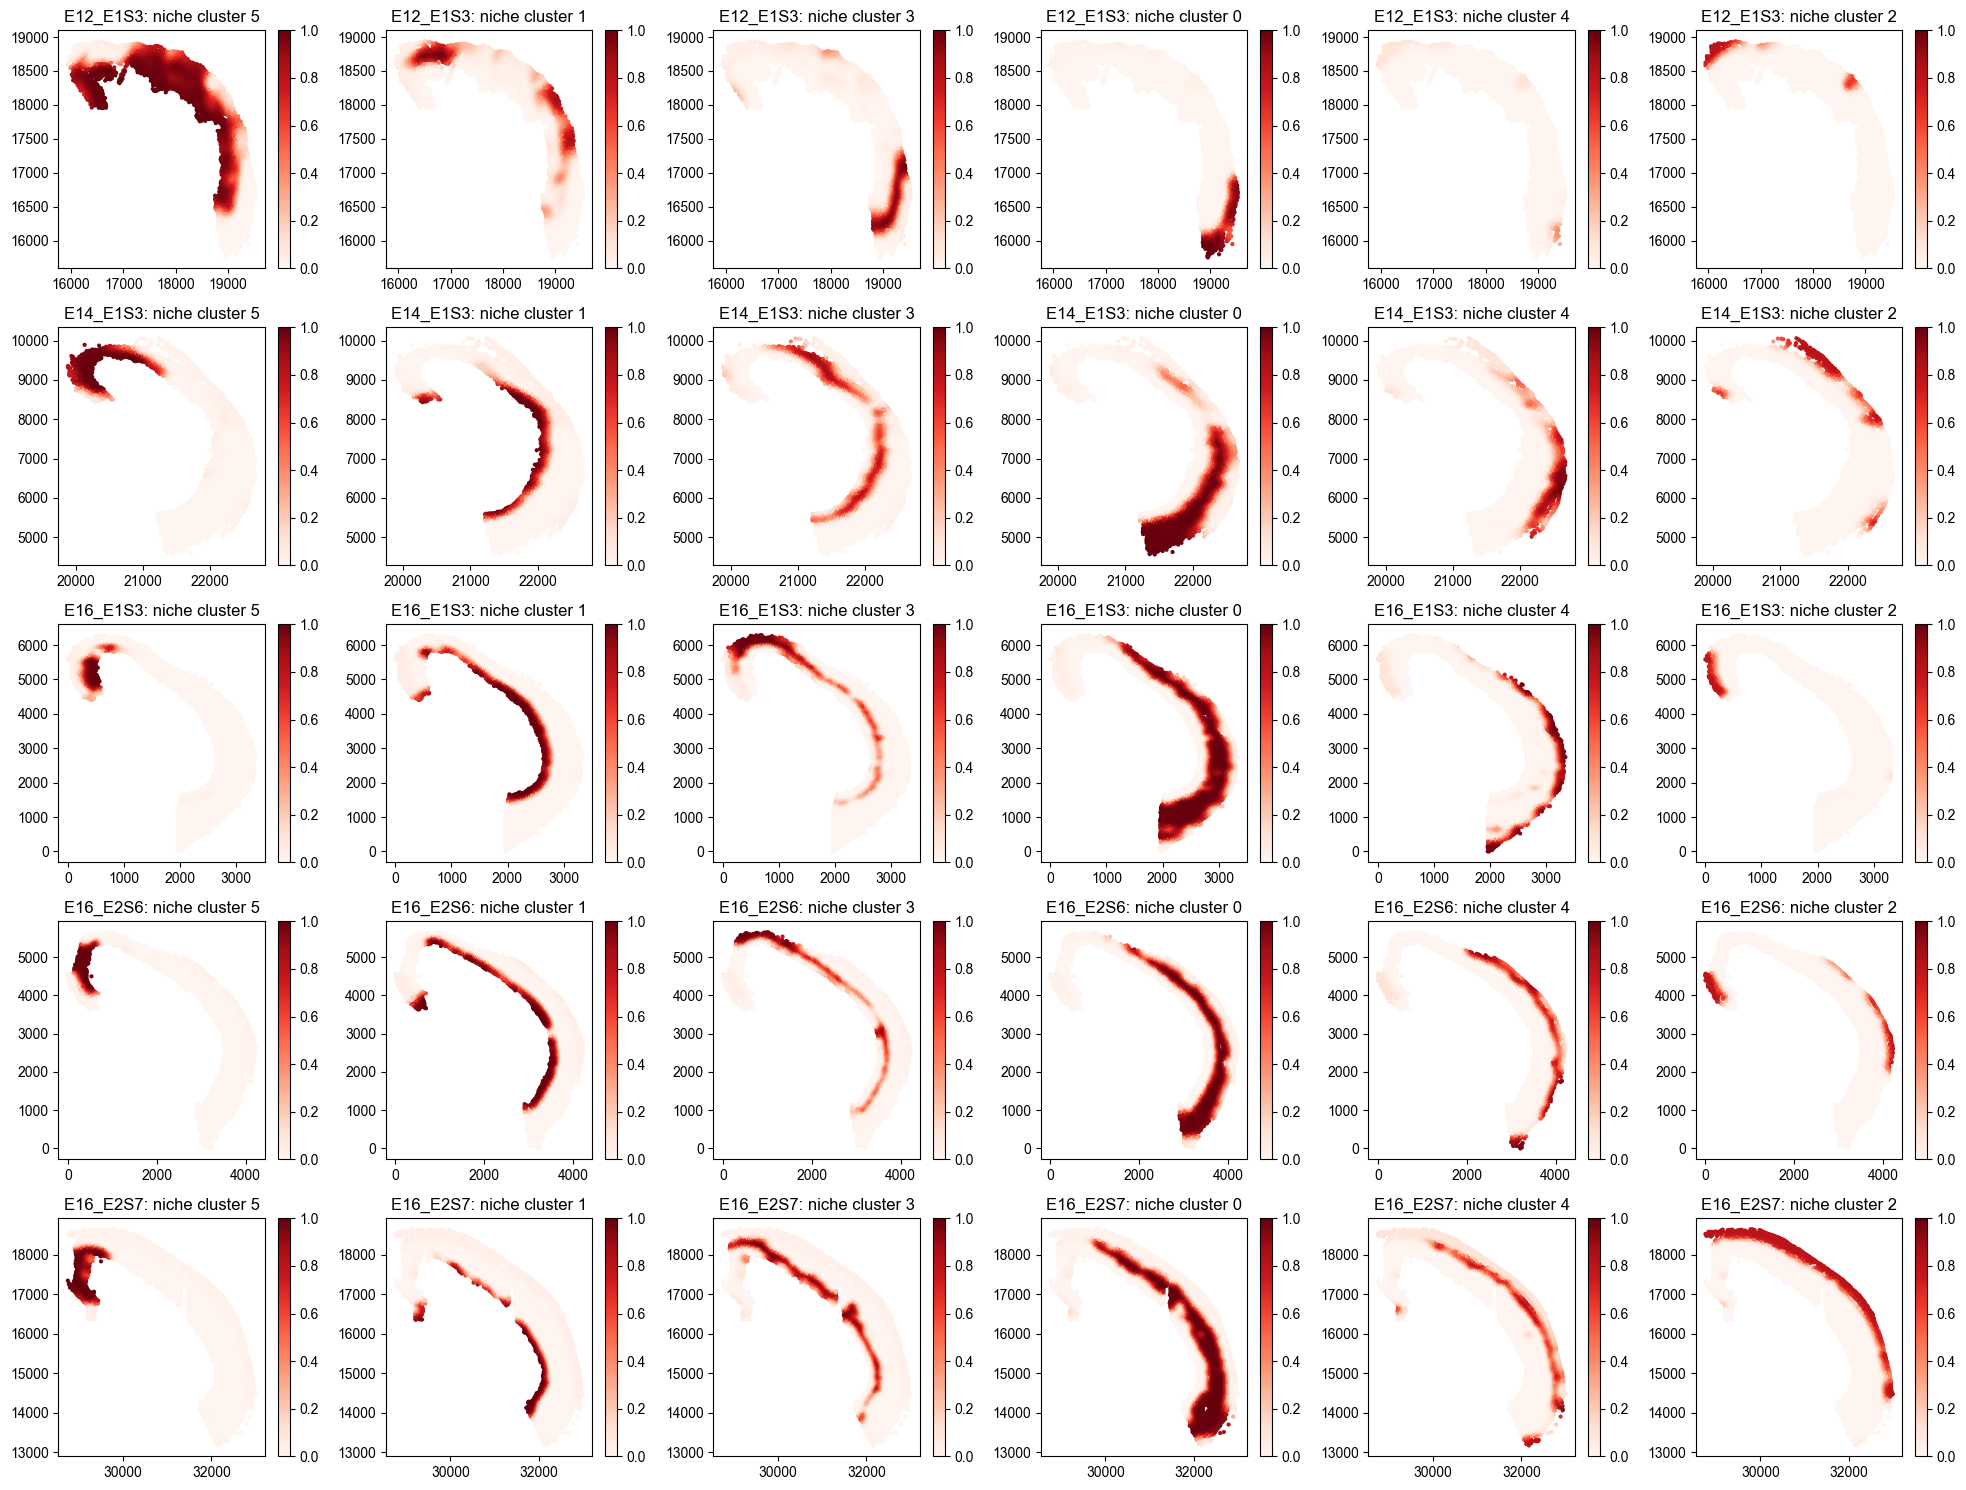

In [35]:
from ONTraC.analysis.niche_cluster import plot_niche_cluster_loadings_dataset_from_anadata

fig, axes = plot_niche_cluster_loadings_dataset_from_anadata(ana_data=ana_data)
fig.savefig('figures/Spatial_niche_clustering_loadings_with_order.png', dpi=100)


##### niche cluster connectivities


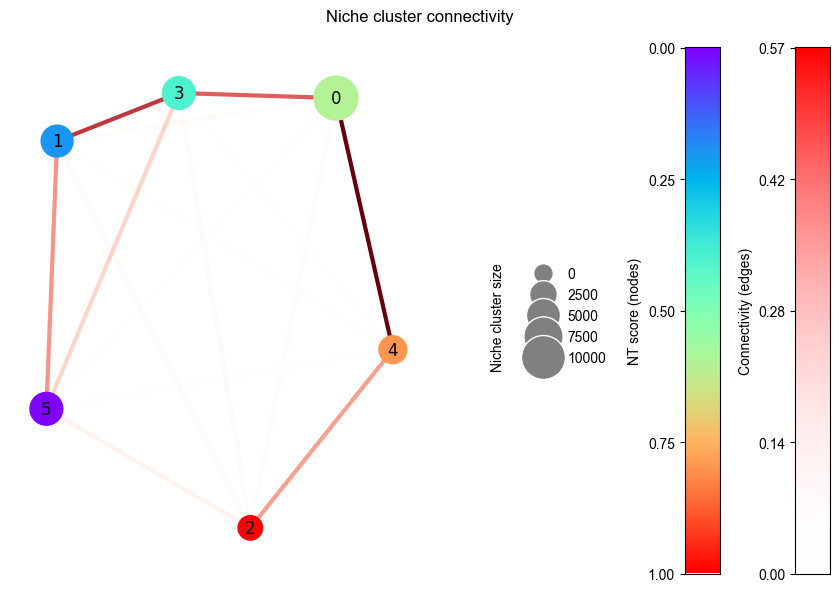

In [36]:
from ONTraC.analysis.niche_cluster import plot_niche_cluster_connectivity_from_anadata

fig, axes = plot_niche_cluster_connectivity_from_anadata(ana_data=ana_data)
fig.savefig('figures/Graph_niche_cluster_conn_with_order.png', dpi=100)


##### cell type loadings in each niche cluster


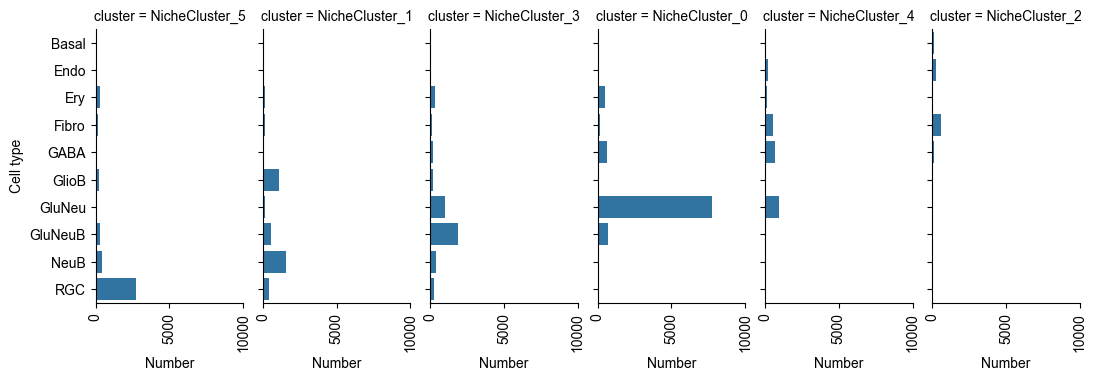

In [37]:
from ONTraC.analysis.cell_type import plot_cell_type_loading_in_niche_clusters_from_anadata

g = plot_cell_type_loading_in_niche_clusters_from_anadata(ana_data=ana_data)
g.savefig('figures/Hist_cell_type_loadings_in_niche_cluster_with_order.png', dpi=100)

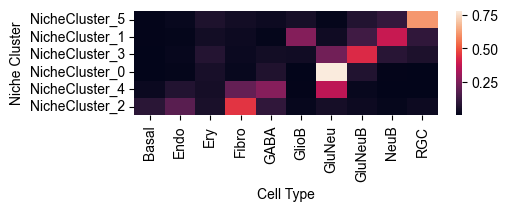

In [38]:
from ONTraC.analysis.cell_type import plot_cell_type_com_in_niche_clusters_from_anadata

fig, ax = plot_cell_type_com_in_niche_clusters_from_anadata(ana_data=ana_data)
fig.savefig('figures/Heatmap_cell_type_composition_in_each_niche_cluster_with_order.png', dpi=100)

This heatmap show the cell type composition within each niche cluster. Sum of each row equals to 1.

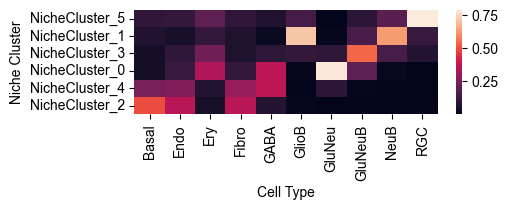

In [39]:
from ONTraC.analysis.cell_type import plot_cell_type_dis_across_niche_cluster_from_anadata

fig, ax = plot_cell_type_dis_across_niche_cluster_from_anadata(ana_data=ana_data)
fig.savefig('figures/Heatmap_cell_type_distribution_across_niche_clusters_with_order.png', dpi=100)

This heatmap show the cell type distribution across niche clusters. Sum of each column equals to 1.